In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import accuracy_score
np.random.seed(42)

### Data

In [3]:
train_path = 'Train'
test_path = 'Test'

# Dataset has images in various sizes so we need to resize them
# Also makes sure we work with 3 channels
image_height = 32
image_width = 32
channels = 3

number_of_categories = len(os.listdir(train_path))

### Dataset preparation

In [4]:
image_data = []
image_labels = []

for i in range(number_of_categories):
    path = train_path + '/' +  str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((image_height, image_width))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

# Shuffle the data
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

# Split the set
x_train, x_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

x_train = x_train/255
x_val = x_val/255

# one hot encoding
y_train = keras.utils.to_categorical(y_train, number_of_categories)
y_val = keras.utils.to_categorical(y_val, number_of_categories)

### CNN model

In [11]:
#Original model
cmodel = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(image_height,image_width,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

# Resnet 50
res = ResNet50(include_top=False, weights="imagenet", input_shape=(image_height,image_width,channels))

# vgg16

vgg = VGG16(include_top=False, weights="imagenet", input_shape=(image_height,image_width,channels))

# Freeze layers
#for layer in vgg.layers[:10]:
#    layer.trainable = False

mobile = MobileNetV2(include_top=False, weights='imagenet', input_shape=(image_height,image_width,channels))

eff = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(image_height,image_width,channels))

model = keras.models.Sequential()
model.add(mobile)
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='sigmoid'))
model.add(keras.layers.Dense(43, activation='softmax'))

16719872/16705208 [==============================] - 1s 0us/step


In [12]:
lr = 0.001
epochs = 10

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### Data Augmentation

In [13]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [14]:
# called history since ity will be used for graphing purposes later
#history = model.fit(aug.flow(x_train, y_train, batch_size=32), epochs=epochs, validation_data=(x_val, y_val))
history = model.fit(aug.flow(x_train, y_train, batch_size=32), epochs=epochs, validation_data=(x_val, y_val))

Epoch 5/10
858/858 [==============================] - 586s 684ms/step - loss: 0.1873 - accuracy: 0.9419 - val_loss: 0.3532 - val_accuracy: 0.8936
Epoch 6/10
858/858 [==============================] - 548s 639ms/step - loss: 0.1649 - accuracy: 0.9505 - val_loss: 0.2397 - val_accuracy: 0.9262
Epoch 7/10
858/858 [==============================] - 545s 635ms/step - loss: 0.1279 - accuracy: 0.9601 - val_loss: 0.2024 - val_accuracy: 0.9397
Epoch 8/10
858/858 [==============================] - 544s 633ms/step - loss: 0.1105 - accuracy: 0.9667 - val_loss: 0.2025 - val_accuracy: 0.9458
Epoch 9/10
858/858 [==============================] - 543s 632ms/step - loss: 0.0963 - accuracy: 0.9715 - val_loss: 0.1091 - val_accuracy: 0.9712
Epoch 10/10
858/858 [==============================] - 560s 653ms/step - loss: 0.0834 - accuracy: 0.9742 - val_loss: 0.1192 - val_accuracy: 0.9670


### Graphing

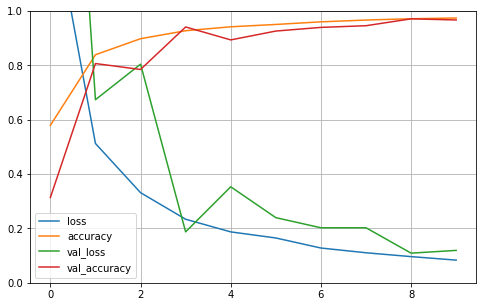

In [15]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Testing

In [16]:
test = pd.read_csv('Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    image = cv2.imread(img)
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((image_height, image_width))
    data.append(np.array(resize_image))
            
X_test = np.array(data)
X_test = X_test/255

pred = np.argmax(model.predict(X_test, verbose=1), axis=-1)

#Accuracy with the test data
print('Test Data accuracy(%): ',accuracy_score(labels, pred)*100)